2025-06-17 11:02:12.815970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750158133.017583      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750158133.074396      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Loading metadata...
Dataset shape: (10015, 7)

First few rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       100

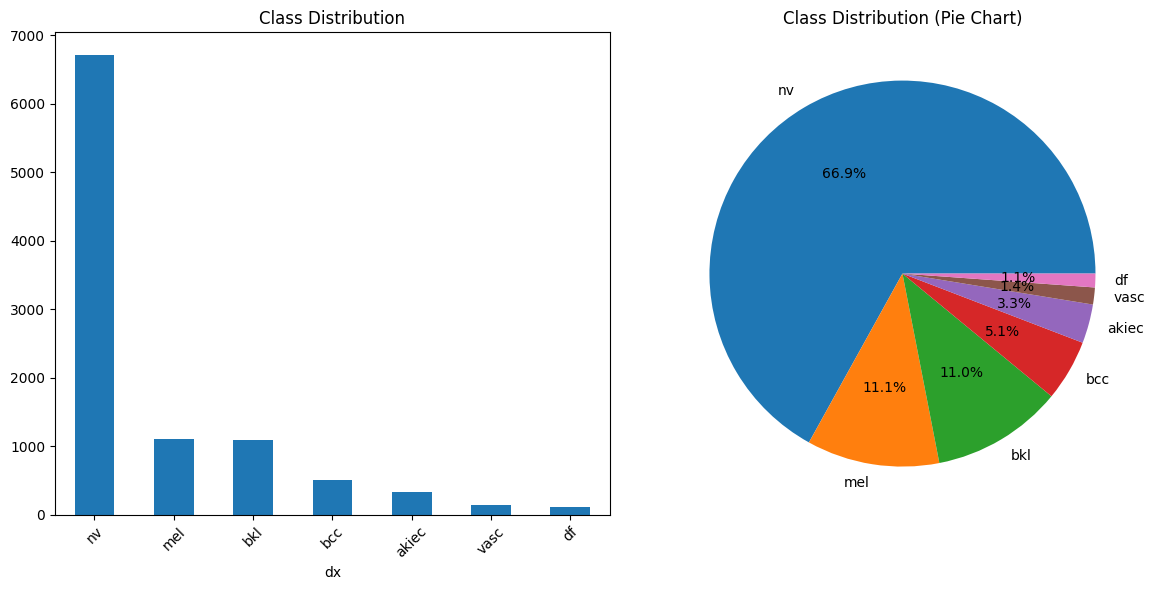

Loading and preprocessing images...
Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Processed 6000 images...
Processed 7000 images...
Processed 8000 images...
Processed 9000 images...
Processed 10000 images...
Successfully loaded 10015 images


In [1]:
# Complete Skin Disease Detection Training Pipeline
# HAM10000 Dataset - 7 Class Classification
# Run this in Kaggle with HAM10000 dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'  # Dedicated GPU threads
os.environ['TF_GPU_THREAD_COUNT'] = '2'  # Experiment with 1-4


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# =============================================================================
# 1. DATA LOADING AND EXPLORATION
# =============================================================================

# Kaggle paths - adjust if needed
BASE_PATH = '/kaggle/input/ham1000'
IMAGES_PATH_1 = f'{BASE_PATH}/HAM10000_images_part_1'
IMAGES_PATH_2 = f'{BASE_PATH}/HAM10000_images_part_2'
METADATA_PATH = f'{BASE_PATH}/HAM10000_metadata.csv'

# Load metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_PATH)
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nClass distribution:")
class_counts = df['dx'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution (Pie Chart)')
plt.show()

# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================
# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================

def remove_hair(img):
    """Hair removal using morphological operations and inpainting"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    return cv2.inpaint(img, threshold, 3, cv2.INPAINT_TELEA)

def load_and_preprocess_image(image_id, img_size=224):
    ...

def load_and_preprocess_image(image_id, img_size=224):
    """Load and preprocess a single image"""
    # Try both directories
    img_path_1 = os.path.join(IMAGES_PATH_1, f'{image_id}.jpg')
    img_path_2 = os.path.join(IMAGES_PATH_2, f'{image_id}.jpg')
    
    if os.path.exists(img_path_1):
        img_path = img_path_1
    elif os.path.exists(img_path_2):
        img_path = img_path_2
    else:
        return None
    
    try:
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = remove_hair(img)  # <-- Insert this line

        
        # Resize
        img = cv2.resize(img, (img_size, img_size))
        
        # Normalize
        img = img.astype(np.float32) / 255.0
        
        return img
    except:
        return None
# Load all images
print("Loading and preprocessing images...")
IMG_SIZE = 32
images = []
labels = []
valid_indices = []

for idx, row in df.iterrows():
    img = load_and_preprocess_image(row['image_id'], IMG_SIZE)
    if img is not None:
        images.append(img)
        labels.append(row['dx'])
        valid_indices.append(idx)
    
    if len(images) % 1000 == 0:
        print(f"Processed {len(images)} images...")

print(f"Successfully loaded {len(images)} images")

Images shape: (10015, 32, 32, 3)
Labels shape: (10015,)


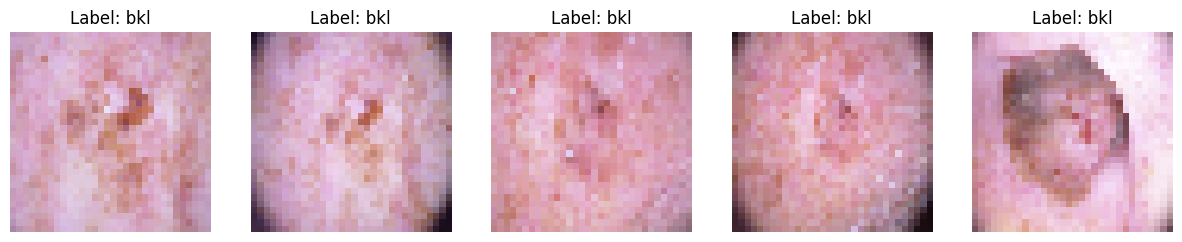

Unique encoded labels: [0 1 2 3 4 5 6]
First 5 labels (encoded): [2 2 2 2 2]


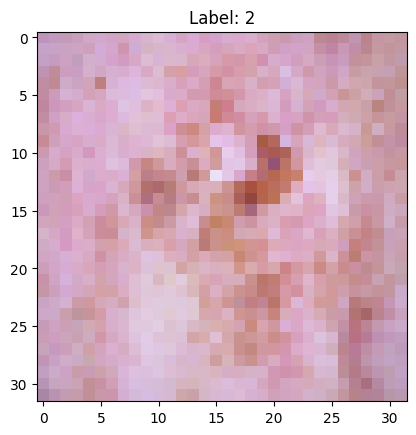

Number of classes: 7
Class mapping:
0: akiec
1: bcc
2: bkl
3: df
4: mel
5: nv
6: vasc


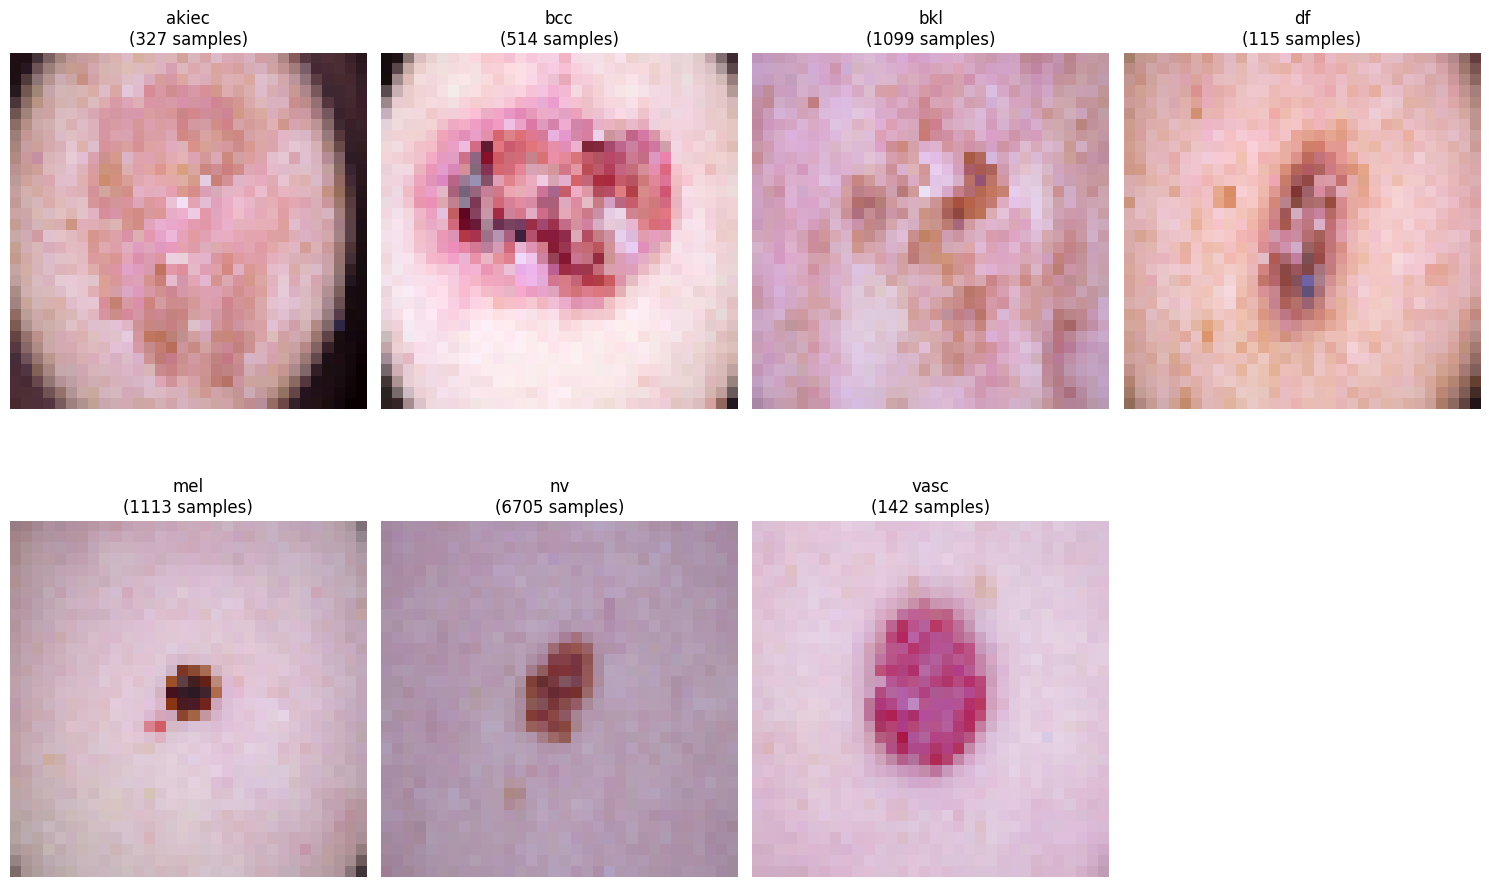

Splitting data...
Training set: 6009 samples
Validation set: 2003 samples
Test set: 2003 samples
Class weights: {0: 4.357505438723713, 1: 2.787105751391466, 2: 1.3026230218946455, 3: 12.440993788819876, 4: 1.2850727117194183, 5: 0.21338020666879728, 6: 10.099159663865546}
Creating model...
Model summary:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 14, 14, 32)          │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,471 (681.53 KB)

 Trainable params: 174,471 (681.53 KB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/20
186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6653 - loss: 1.1537
Epoch 1: val_loss improved from inf to 0.94741, saving model to best_model.h5
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6654 - loss: 1.1524 - val_accuracy: 0.6729 - val_loss: 0.9474 - learning_rate: 0.0010
Epoch 2/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.8705
Epoch 2: val_loss did not improve from 0.94741
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.8705 - val_accuracy: 0.6729 - val_loss: 0.9475 - learning_rate: 9.5000e-04
Epoch 3/20
177/187 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6708 - loss: 0.9376
Epoch 3: val_loss improved from 0.94741 to 0.91092, saving model to best_model.h5
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6712 - loss: 0.9368 - val_accuracy: 0.6885 - val_loss: 0.9109 - learning_rate: 9.0250e-04
Epoch 4/20
  1/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7188 - loss: 0.

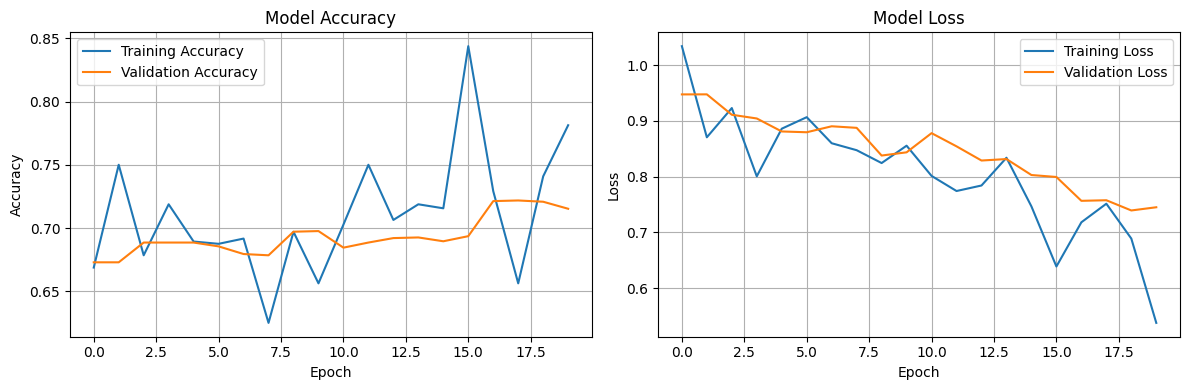

Evaluating model on test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.50      0.09      0.16        65
         bcc       0.44      0.64      0.52       103
         bkl       0.46      0.45      0.46       220
          df       1.00      0.04      0.08        23
         mel       0.41      0.35      0.38       223
          nv       0.84      0.90      0.87      1341
        vasc       0.54      0.25      0.34        28

    accuracy                           0.73      2003
   macro avg       0.60      0.39      0.40      2003
weighted avg       0.72      0.73      0.71      2003



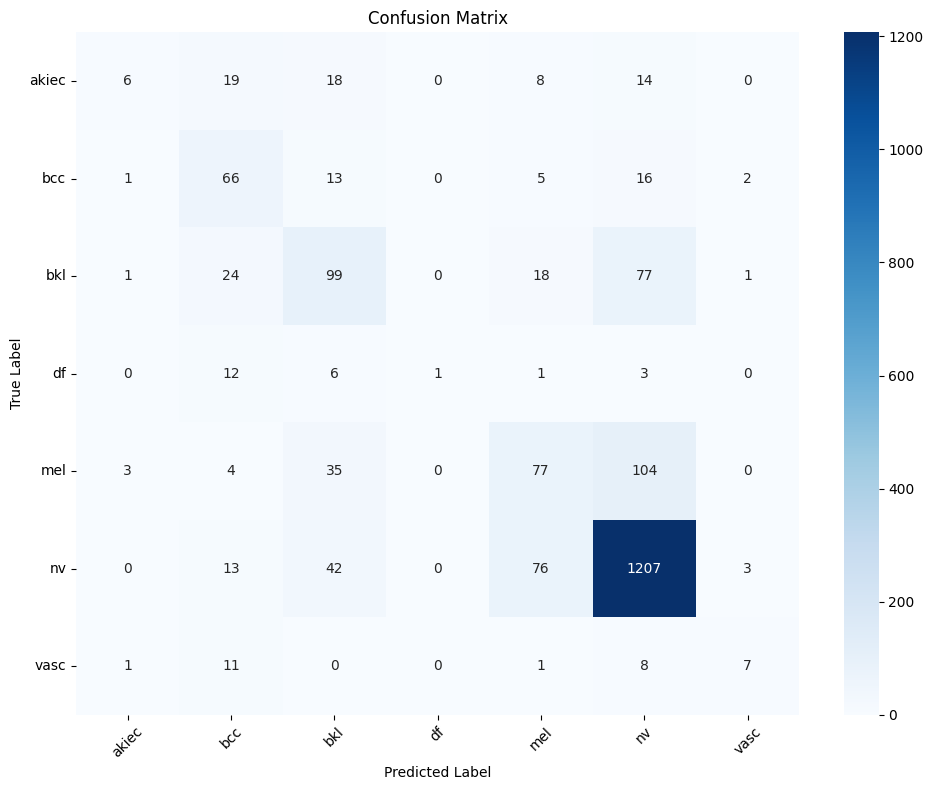


Test Accuracy: 0.7304
Saving model and artifacts...
Model saved as 'skin_disease_detector_final.h5'
Label encoder saved as 'label_encoder.pkl'
Model configuration saved as 'model_config.json'

Testing prediction function...
Sample prediction result: {'error': 'Graph execution error:\n\nDetected at node sequential_11_1/flatten_11_1/Reshape defined at (most recent call last):\n<stack traces unavailable>\nonly one input size may be -1, not both 0 and 1\n\nStack trace for op definition: \nFile "<frozen runpy>", line 198, in _run_module_as_main\nFile "<frozen runpy>", line 88, in _run_code\nFile "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>\nFile "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance\nFile "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start\nFile "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start\nFile "/usr/lib

In [ ]:
# Complete Skin Disease Detection Training Pipeline
# HAM10000 Dataset - 7 Class Classification
# Run this in Kaggle with HAM10000 dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'  # Dedicated GPU threads
os.environ['TF_GPU_THREAD_COUNT'] = '2'  # Experiment with 1-4


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# =============================================================================
# 1. DATA LOADING AND EXPLORATION
# =============================================================================

# Kaggle paths - adjust if needed
BASE_PATH = '/kaggle/input/ham1000'
IMAGES_PATH_1 = f'{BASE_PATH}/HAM10000_images_part_1'
IMAGES_PATH_2 = f'{BASE_PATH}/HAM10000_images_part_2'
METADATA_PATH = f'{BASE_PATH}/HAM10000_metadata.csv'

# Load metadata
print("Loading metadata...")
df = pd.read_csv(METADATA_PATH)
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nClass distribution:")
class_counts = df['dx'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution (Pie Chart)')
plt.show()

# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================
# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================

def remove_hair(img):
    """Hair removal using morphological operations and inpainting"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    return cv2.inpaint(img, threshold, 3, cv2.INPAINT_TELEA)

def load_and_preprocess_image(image_id, img_size=224):
    ...

def load_and_preprocess_image(image_id, img_size=224):
    """Load and preprocess a single image"""
    # Try both directories
    img_path_1 = os.path.join(IMAGES_PATH_1, f'{image_id}.jpg')
    img_path_2 = os.path.join(IMAGES_PATH_2, f'{image_id}.jpg')
    
    if os.path.exists(img_path_1):
        img_path = img_path_1
    elif os.path.exists(img_path_2):
        img_path = img_path_2
    else:
        return None
    
    try:
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = remove_hair(img)  # <-- Insert this line

        
        # Resize
        img = cv2.resize(img, (img_size, img_size))
        
        # Normalize
        img = img.astype(np.float32) / 255.0
        
        return img
    except:
        return None
# Load all images
print("Loading and preprocessing images...")
IMG_SIZE = 32
images = []
labels = []
valid_indices = []

for idx, row in df.iterrows():
    img = load_and_preprocess_image(row['image_id'], IMG_SIZE)
    if img is not None:
        images.append(img)
        labels.append(row['dx'])
        valid_indices.append(idx)
    
    if len(images) % 1000 == 0:
        print(f"Processed {len(images)} images...")

print(f"Successfully loaded {len(images)} images")# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)



print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i])
    plt.title(f"Label: {label_encoder.inverse_transform([y_encoded[i]])[0]}")
    plt.axis('off')
plt.show()
print("Unique encoded labels:", np.unique(y_encoded))
print("First 5 labels (encoded):", y_encoded[:5])
plt.imshow(X[0])
plt.title(f"Label: {y_encoded[0]}")
plt.show()
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print("Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

# =============================================================================
# 3. DATA VISUALIZATION
# =============================================================================

# Display sample images from each class
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(label_encoder.classes_):
    # Find first image of this class
    class_indices = np.where(y == class_name)[0]
    if len(class_indices) > 0:
        img_idx = class_indices[0]
        plt.subplot(2, 4, i+1)
        plt.imshow(X[img_idx])
        plt.title(f'{class_name}\n({len(class_indices)} samples)')
        plt.axis('off')

plt.tight_layout()
plt.show()

# =============================================================================
# 4. TRAIN-VALIDATION-TEST SPLIT
# =============================================================================

print("Splitting data...")
# First split: train+val vs test (80% vs 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Second split: train vs val (80% vs 20% of the remaining 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# =============================================================================
# 5. DATA AUGMENTATION
# =============================================================================

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation
val_datagen = ImageDataGenerator()

# Create data generators
batch_size = 32

#train_generator = train_datagen.flow(
train_generator = val_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

# =============================================================================
# 6. MODEL ARCHITECTURE
# =============================================================================

def create_model(input_shape=(30, 30, 1), num_classes=7):  # Note: changed input shape
    """Create simple CNN model"""
    
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (1, 1), activation='relu'),  # 1x1 conv to maintain spatial dims
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, None  # Return None for base_model since we don't have one
from tensorflow.keras.losses import Loss
import tensorflow as tf

class SparseCategoricalFocalLoss(Loss):
    def __init__(self, alpha=0.25, gamma=2.0, from_logits=False, name="sparse_categorical_focal_loss"):
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        # Convert sparse labels to one-hot encoding
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        
        # Process predictions
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # Calculate focal loss
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        loss = self.alpha * tf.pow(1.0 - y_pred, self.gamma) * cross_entropy
        
        return tf.reduce_sum(loss, axis=-1)

# Create model
print("Creating model...")
model, base_model = create_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes)
# Calculate alpha based on class distribution (replace class weights)
alpha_values = 1.0 / class_weights  # Inverse of class weights
focal_loss = SparseCategoricalFocalLoss(
    alpha=alpha_values,
    gamma=2.0,
    from_logits=False  # Set True if not using softmax
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model summary:")
model.summary()

# =============================================================================
# 7. CALLBACKS AND TRAINING SETUP
# =============================================================================
from tensorflow.keras.callbacks import TensorBoard

callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',  # More stable than val_accuracy
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',  # More reliable stopping criterion
        mode='min',
        patience=20,  # Longer patience for medical imaging
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001  # Only stop if improvement < 0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  # Consistent with other callbacks
        mode='min',
        factor=0.2,  # More aggressive LR reduction (0.5 → 0.2)
        patience=8,
        min_lr=1e-8,  # Lower minimum (1e-7 → 1e-8)
        verbose=1,
        cooldown=3  # Wait 3 epochs after LR reduction
    ),
    # Add learning rate scheduling
    tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-3 * (0.95 ** epoch),  # Gradual decay
        verbose=0
    ),
    TensorBoard(log_dir='logs', histogram_freq=1)
]

# =============================================================================
# 8. TRAINING PHASE 1: FROZEN BASE MODEL
# =============================================================================

print("Starting training...")

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=20,  # Adjust epochs as needed
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    callbacks=callbacks,
    verbose=1
)
# =============================================================================
# 10. TRAINING VISUALIZATION
# =============================================================================

# Plot single training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
 

# =============================================================================
# 11. MODEL EVALUATION
# =============================================================================

print("Evaluating model on test set...")

# Predictions on test set
test_predictions = model.predict(X_test, batch_size=batch_size)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_test, 
    test_pred_classes, 
    target_names=label_encoder.classes_
))

# Confusion matrix
cm = confusion_matrix(y_test, test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate accuracy
test_accuracy = np.mean(test_pred_classes == y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# =============================================================================
# 12. SAVE MODEL AND ARTIFACTS
# =============================================================================

print("Saving model and artifacts...")

# Save the trained model
model.save('skin_disease_detector_final.h5')
print("Model saved as 'skin_disease_detector_final.h5'")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

# Save model configuration
model_config = {
    'input_shape': (IMG_SIZE, IMG_SIZE, 3),
    'num_classes': num_classes,
    'class_names': label_encoder.classes_.tolist(),
    'img_size': IMG_SIZE,
    'test_accuracy': float(test_accuracy)
}

import json
with open('model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)
print("Model configuration saved as 'model_config.json'")

# =============================================================================
# 13. PREDICTION FUNCTION FOR DEPLOYMENT
# =============================================================================

def predict_skin_disease(image_path, model, label_encoder, img_size=224):
    """
    Predict skin disease from image path
    """
    try:
        # Load and preprocess image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)
        
        # Make prediction
        predictions = model.predict(img)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]
        predicted_class = label_encoder.classes_[predicted_class_idx]
        
        # Get all class probabilities
        class_probabilities = {}
        for i, class_name in enumerate(label_encoder.classes_):
            class_probabilities[class_name] = float(predictions[0][i])
        
        return {
            'predicted_class': predicted_class,
            'confidence': float(confidence),
            'all_probabilities': class_probabilities
        }
    
    except Exception as e:
        return {'error': str(e)}

# Test the prediction function with a sample image
if len(X_test) > 0:
    print("\nTesting prediction function...")
    # Create a temporary test image
    test_img = (X_test[0] * 255).astype(np.uint8)
    cv2.imwrite('temp_test_image.jpg', cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR))
    
    # Test prediction
    result = predict_skin_disease('temp_test_image.jpg', model, label_encoder)
    print("Sample prediction result:", result)
    
    # Clean up
    os.remove('temp_test_image.jpg')

print("\n" + "="*50)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Model saved as: skin_disease_detector_final.h5")
print(f"Label encoder saved as: label_encoder.pkl")
print(f"Configuration saved as: model_config.json")
print("="*50)

# Display final results summary
print("\nFINAL RESULTS SUMMARY:")
print(f"• Dataset: HAM10000 ({len(images)} images)")
print(f"• Classes: {num_classes}")
print(f"• Architecture: EfficientNetB3 + Custom Head")
print(f"• Test Accuracy: {test_accuracy:.4f}")
print(f"• Model Size: {os.path.getsize('skin_disease_detector_final.h5') / (1024*1024):.1f} MB")


In [4]:
print("History keys (phase 1):", history_phase1.history.keys())
print("History keys (phase 2):", history_phase2.history.keys())


History keys (phase 1): dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
History keys (phase 2): dict_keys([])
